In [10]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import glob
import pandas as pd
#pip install plotly==5.3.1
from ipynb.fs.full.ploty_zoom import zoom

root       = "./samples/"
NORMAL     = "./samples/normal/"
AGLOMERADO = "./samples/aglomerado/"

directory = AGLOMERADO


In [11]:
def getManualCount(name):
    img = cv2.imread(name,1)
    hsv = cv2.cvtColor(img,cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(hsv, (0,200,200), (16,255,255))
    cells, _, _, _ = cv2.connectedComponentsWithStats(mask, 4, cv2.CV_32S)
    
    mask = cv2.inRange(hsv, (17,200,200), (76,255,255))
    internal, _, _, _ = cv2.connectedComponentsWithStats(mask, 4, cv2.CV_32S)
    
    mask = cv2.inRange(hsv, (0,0,0), (1,1,255))
    mask = cv2.erode(mask,np.ones((15,15),np.uint8))
    external, _, cc, _ = cv2.connectedComponentsWithStats(mask, 4, cv2.CV_32S)
    
    for c in cc:
        cv2.circle(img, (int(c[0]), int(c[1])), 25, (255,255,255), -1)
    
    return {"method":"Manual",
            "cells":cells-1,
            "internal":internal-1,
            "external":external-1,
            "path":name,
            "time":0}


def getOriginalCount(name):
    name1 = name.replace(directory,root+"result/") + "_resultText.txt"
    f = open(name1,'r')
    txt = f.read().replace("\x00"," ")
    f.close()
    lines = txt.split("\n")
    data = lines[1].split()
    cells = int(data[1])
    #no txt do proj original esta saindo a contagem errada
    #infectados sao os que estao externos as celulas
    external = int(data[2])
    internal = int(data[3])
    
    
    return {"method"  :"Original",
            "cells"   :cells,
            "internal":internal,
            "external":external,
            "time"    :float(data[4]),
            "path"    :name+"_segmented.jpg"}

def getProjectCount(name):
    name = name.replace(directory,root+"myresults/") + "_result.txt"
    f = open(name,'r')
    txt = f.read().replace("\x00"," ")
    f.close()
    lines = txt.split("\n")
    ret = []
    for i in range(1,len(lines),1):
        data = lines[i].split("\t")
        if len(data) > 1:
            ret.append({
                'method'  : data[0].strip(),
                'cells'   : int(data[1].strip()),
                'internal': int(data[2].strip()),
                'external': int(data[3].strip()),
                'time'    : float(data[4].strip().replace("s","")),
                'path'    : data[5].strip(),
            })
    return ret


def add_to_samples(samples,values):
    if "cells_error" not in values.keys():
        values['cells_error'] = -1
    if "internal_error" not in values.keys():
        values['internal_error'] = -1
    if "external_error" not in values.keys():
        values['external_error'] = -1
        
    samples['method'].append(values["method"])
    samples['cells'].append(values["cells"])
    samples['internal'].append(values["internal"])
    samples['external'].append(values["external"])
    samples['time'].append(values["time"])
    samples['path'].append(values["path"])
    samples['cells_error'].append(values["cells_error"])
    samples['internal_error'].append(values["internal_error"])
    samples['external_error'].append(values["external_error"])
    
def calc_error(manual,dt):
    dt['cells_error']    = abs(manual["cells"]    - dt["cells"])
    dt['internal_error'] = abs(manual["internal"] - dt["internal"])
    dt['external_error'] = abs(manual["external"] - dt["external"])
    return dt


samples = {"sample":[],
           "method":[],
           "cells":[],
           "internal":[],
           "external":[],
           "time":[],
           "path":[],
           "cells_error":[],
           "internal_error":[],
           "external_error":[]}

qtd = 0
for file in glob.glob(directory+"*_count.jpg"):
    qtd += 1
#for i in range(1,15,1):
    file = file.replace("\\","/").lower()
    #file = directory + "blood_smear_%d_count.jpg" % i
    name = file.replace("_count.jpg","")
    sample_name = name.replace(directory,"")
    
    samples['sample'].append(sample_name)
    
    manual = getManualCount(file)
    add_to_samples(samples,manual)
    
    data = getProjectCount(name)
    for dt in data:
        samples['sample'].append(sample_name)
        dt = calc_error(manual,dt)
        add_to_samples(samples,dt)
    
    
    orig = getOriginalCount(name)
    samples['sample'].append(sample_name)
    orig = calc_error(manual,orig)
    add_to_samples(samples,orig)

    
print ("QTD:",qtd)
samples = pd.DataFrame(data=samples)
samples

QTD: 4


sample           method  cells  internal  external      time  \
0   blood_smear_12           Manual     87         1         0   0.00000   
1   blood_smear_12             OTSU     70        13        12   4.00000   
2   blood_smear_12  OTSU w/out blur     68         4        38  10.94000   
3   blood_smear_12              HSV     31         1         2  13.47000   
4   blood_smear_12  HSV w/out erode     69         2         1   2.63000   
5   blood_smear_12        Watershed     73         1         8   4.33000   
6   blood_smear_12     HoughCircles     94        29        15  10.40000   
7   blood_smear_12         Original     98         7         3   1.37236   
8   blood_smear_13           Manual     97         1         0   0.00000   
9   blood_smear_13             OTSU     76         2         0   1.33000   
10  blood_smear_13  OTSU w/out blur     64         2         4   2.23000   
11  blood_smear_13              HSV     58         1         0  21.27000   
12  blood_smear_13  HSV w/out erode     66         1         0  22.85000   
13  blood_smear_13        Watershed     96         1         4   3.16000   
14  blood_smear_13     HoughCircles     90         4         2   2.05000   
15  blood_smear_13         Original    131         4         0   1.37414   
16   blood_smear_8           Manual     84         0         3   0.00000   
17   blood_smear_8             OTSU     66         2         0   1.21000   
18   blood_smear_8  OTSU w/out blur     71         2         0   1.19000   
19   blood_smear_8              HSV      0         0         3  11.50000   
20   blood_smear_8  HSV w/out erode      0         0         3   0.36000   
21   blood_smear_8        Watershed     89         3         0   1.72000   
22   blood_smear_8     HoughCircles     90         1         1   1.12000   
23   blood_smear_8         Original     87         5         3   1.17684   
24   blood_smear_9           Manual     72         1         1   0.00000   
25   blood_smear_9             OTSU     69         2         4   1.74000   
26   blood_smear_9  OTSU w/out blur     64         1         7   2.55000   
27   blood_smear_9              HSV     44         0         3  15.59000   
28   blood_smear_9  HSV w/out erode     57         1         2  11.32000   
29   blood_smear_9        Watershed     69         0        16   5.78000   
30   blood_smear_9     HoughCircles     70         5         4   2.36000   
31   blood_smear_9         Original    114        13         1   1.81379   

                                                 path  cells_error  \
0       ./samples/aglomerado/blood_smear_12_count.jpg           -1   
1         ./samples/segmented/blood_smear_12_otsu.png           17   
2   ./samples/segmented/blood_smear_12_otsu_out_bl...           19   
3          ./samples/segmented/blood_smear_12_hsv.png           56   
4   ./samples/segmented/blood_smear_12_hsv_out_ero...           18   
5    ./samples/segmented/blood_smear_12_watershed.png           14   
6        ./samples/segmented/blood_smear_12_hough.png            7   
7   ./samples/aglomerado/blood_smear_12_segmented.jpg           11   
8       ./samples/aglomerado/blood_smear_13_count.jpg           -1   
9         ./samples/segmented/blood_smear_13_otsu.png           21   
10  ./samples/segmented/blood_smear_13_otsu_out_bl...           33   
11         ./samples/segmented/blood_smear_13_hsv.png           39   
12  ./samples/segmented/blood_smear_13_hsv_out_ero...           31   
13   ./samples/segmented/blood_smear_13_watershed.png            1   
14       ./samples/segmented/blood_smear_13_hough.png            7   
15  ./samples/aglomerado/blood_smear_13_segmented.jpg           34   
16       ./samples/aglomerado/blood_smear_8_count.jpg           -1   
17         ./samples/segmented/blood_smear_8_otsu.png           18   
18  ./samples/segmented/blood_smear_8_otsu_out_blu...           13   
19          ./samples/segmented/blood_smear_8_hsv.png           84   
20  ./samples/segmented/blood_sme

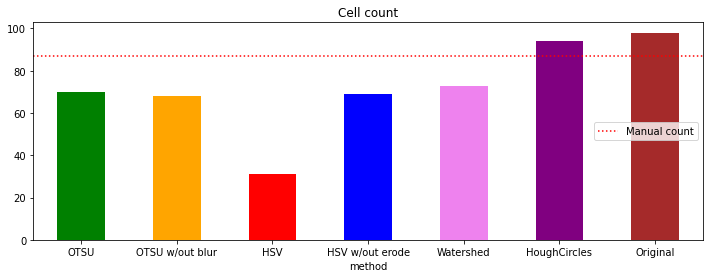

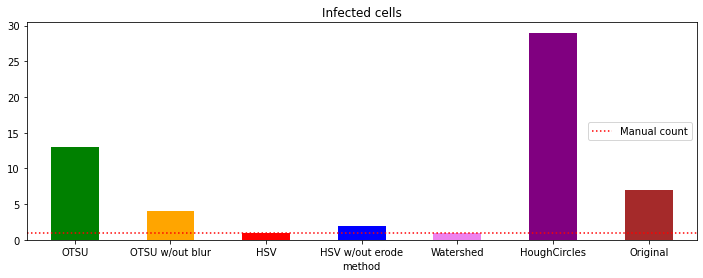

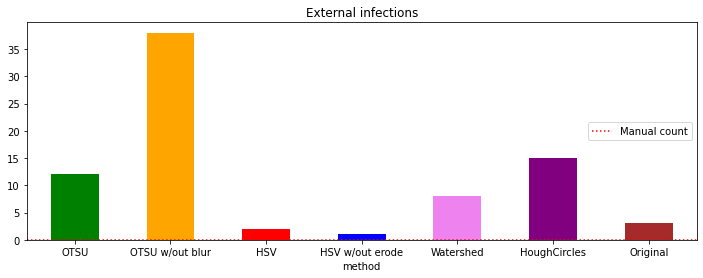

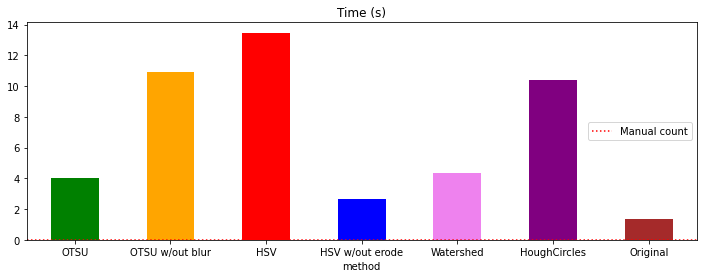

In [24]:
def graph(smp_name,value):
    smp = samples.query("method != 'Manual' & sample == '%s'"%smp_name)
    ax = smp[["method",value]].plot.bar(x='method',
                                        y=value,
                                        color=['green','orange','red','blue','violet','purple','brown'],
                                        title=smp_name,
                                        figsize=(12,4),
                                        rot=0)
    manual_count = samples.query("method == 'Manual' & sample == '%s'" % smp_name).iloc[0][value]


    ax.axhline(y=manual_count, color='r', linestyle='dotted')
    ax.get_legend().remove()
    plt.legend(labels = ['Manual count'],loc='center right')
    
    if value == 'cells':
        plt.title('Cell count')
    if value == 'internal':
        plt.title('Infected cells')
    if value == 'external':
        plt.title('External infections')
    if value == 'time':
        plt.title('Time (s)')
    
    
graph(samples['sample'].iloc(0)[0],"cells")
graph(samples['sample'].iloc(0)[0],"internal")
graph(samples['sample'].iloc(0)[0],"external")
graph(samples['sample'].iloc(0)[0],"time")

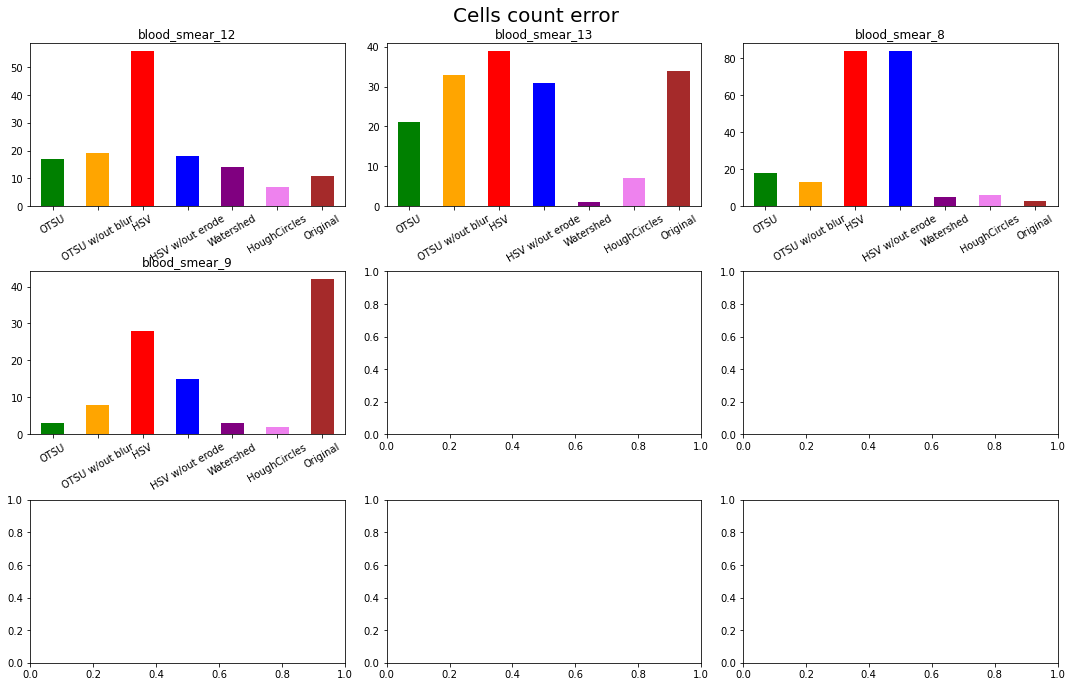

In [25]:
samples_list = samples[["sample"]].drop_duplicates().values
samples_list = samples_list.reshape(len(samples_list))

fig, axes = plt.subplots(ncols=3,nrows=3,figsize=(15,10))
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.suptitle("Cells count error", fontsize=20)
plt.subplots_adjust(hspace = .4)

pos = [(j,i) for j in range(3) for i in range(3)]
i = 0
for smp_name in samples_list:

    smp = samples.query("method != 'Manual' & sample == '%s'" % smp_name)
    ax = smp[["method","cells_error"]].plot.bar(x='method',
                                                y='cells_error',
                                                color=['green','orange','red','blue','purple','violet','brown'],
                                                ax=axes[pos[i]],
                                                title=smp_name,
                                                rot=30)
    ax.get_legend().remove()
    ax.set_xlabel('')
    i += 1



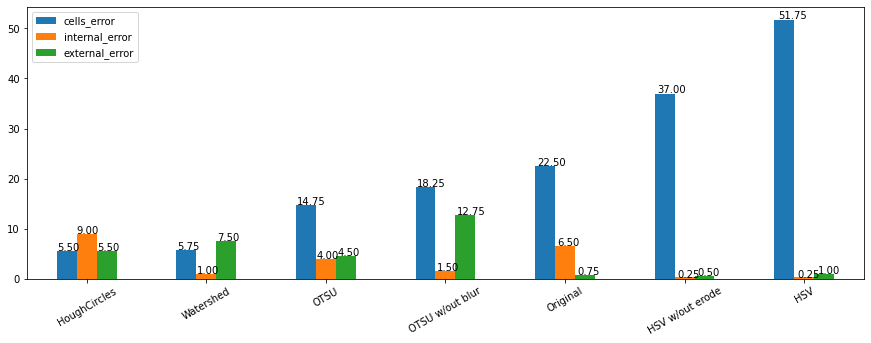

In [26]:
smp = samples.query("method != 'Manual'")
smp = smp[["method","cells_error","internal_error","external_error"]].groupby("method").mean().sort_values("cells_error")
#smp
ax = smp.plot.bar(figsize=(15,5),rot=30)
ax.set_xlabel('')
for p in ax.patches:
    ax.annotate("%.2f"  % p.get_height(), (p.get_x() * 1.005, p.get_height() * 1.005))

In [27]:
samples_list = samples[["sample"]].drop_duplicates().values
samples_list = samples_list.reshape(len(samples_list))

#methods
cols = 6 #1-8 max
#samples
rows = 7


fig, axes = plt.subplots(nrows=rows,ncols=cols,figsize=(30,30))
fig.tight_layout(rect=[0, .03, 0.5, 0.95])
fig.suptitle("Cells count error", fontsize=20, x=0.1)
plt.subplots_adjust( hspace=0.4 )

pos = [(j,i) for j in range(rows) for i in range(cols)]
i = 0
for smp_name in samples_list:

    smp = samples.query("method != 'Manual' & sample == '%s'" % smp_name)
    smp = pd.concat([smp.query("method != 'Original'").nsmallest(cols-2,'cells_error'),
                     smp.loc[smp['method'] == "Original"]])
    ax = smp[["method","cells_error"]].plot.bar(x='method',
                                                y='cells_error',
                                                color=['green','orange','red','blue','purple'],
                                                ax=axes[pos[i]],
                                                title=smp_name,
                                                rot=30)
    ax.get_legend().remove()
    ax.set_xlabel('')
    i += 1
    
    for v in smp.values:
        img = cv2.cvtColor(cv2.imread(v[6]),cv2.COLOR_BGR2RGB)
        axes[pos[i]].set_title(v[1])
        axes[pos[i]].imshow(img)
        axes[pos[i]].axis('off')
        i += 1

plt.savefig("tmpa4.png",dpi=300)
plt.close()
#sometimes it make a cache of image
#change the image name
zoom("tmpa4.png")


# HoughCircles x Original

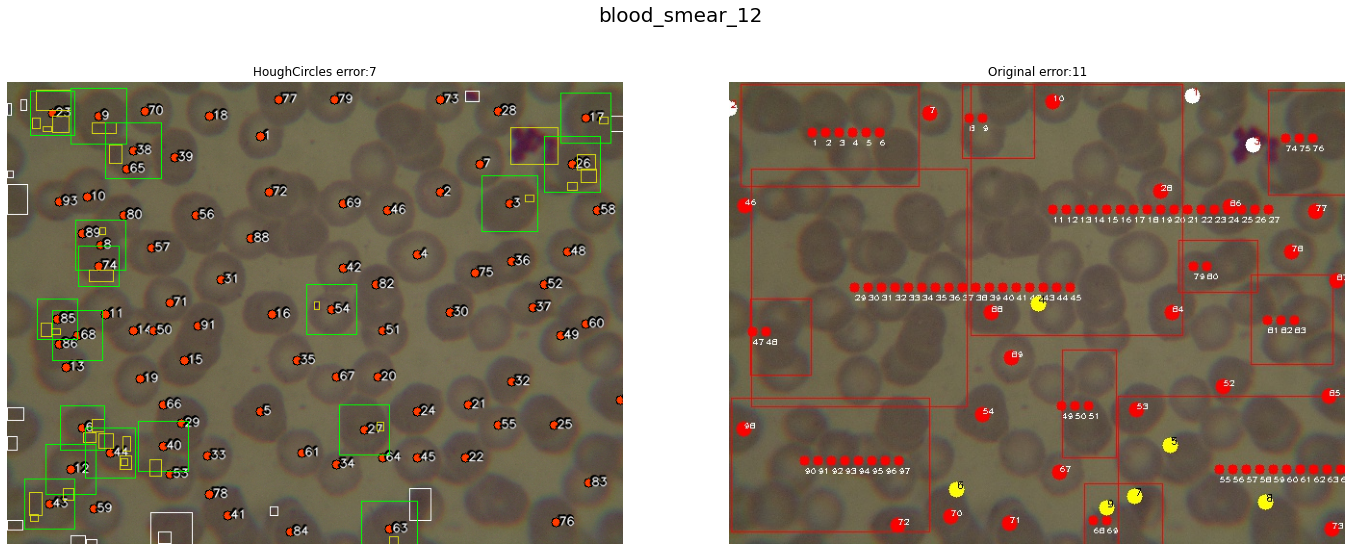

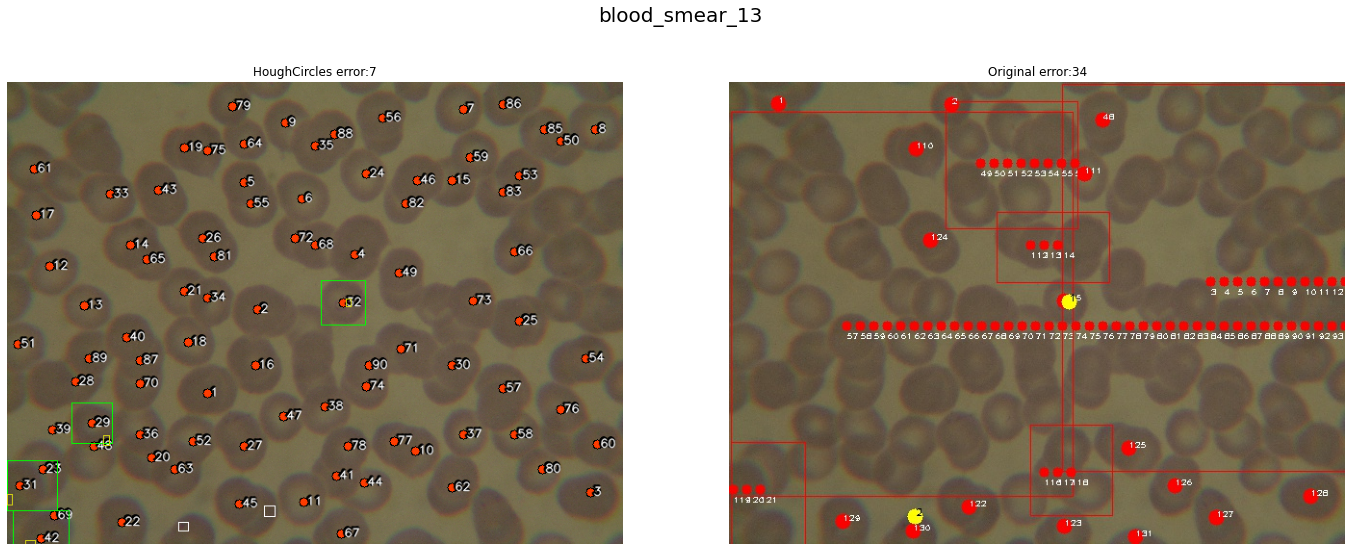

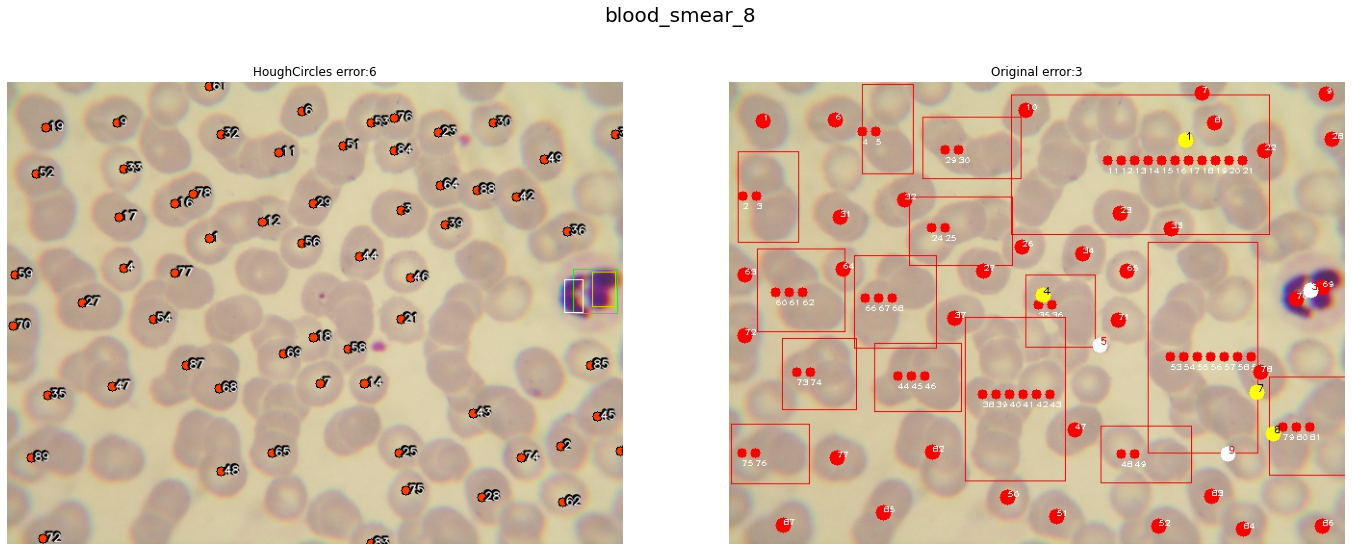

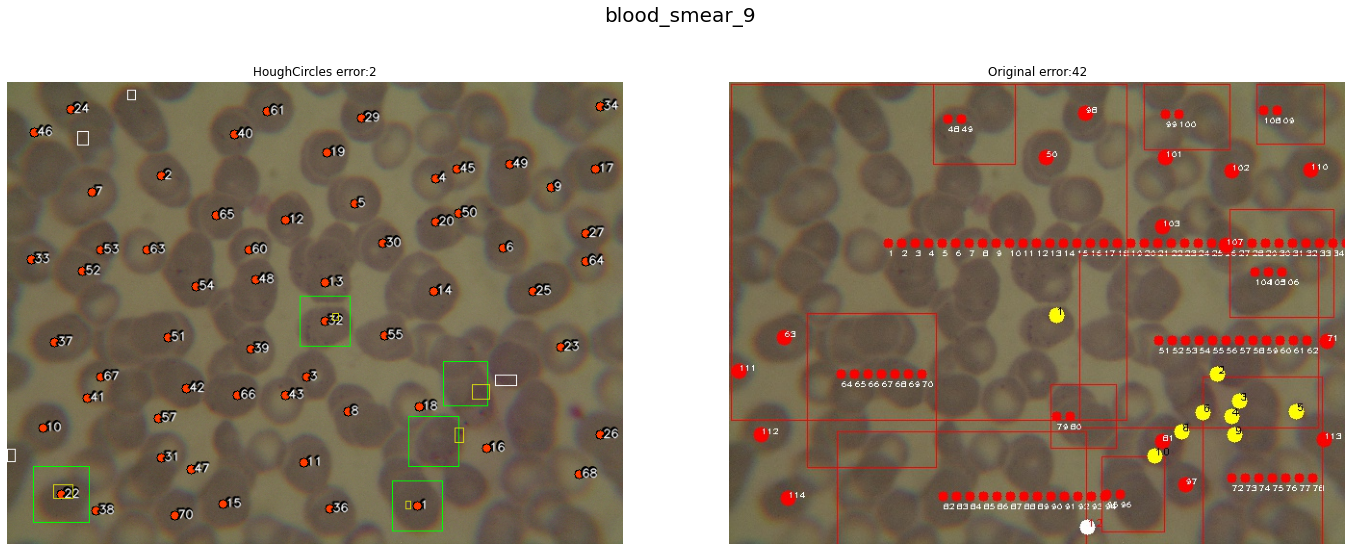

In [28]:
smp = samples.query("method in ['HoughCircles','Original']")


k = 0
for v in smp.values:
    if k == 0:
        fig, axes = plt.subplots(ncols=2,figsize=(20,8))
    fig.tight_layout(rect=[0, 0, 1, 0.95])
    fig.suptitle(v[0],fontsize=20)
    img = cv2.cvtColor(cv2.imread(v[6]),cv2.COLOR_BGR2RGB)
    
    axes[k].set_title(v[1]+ " error:%d" % (v[7]))
    axes[k].imshow(img)
    axes[k].axis('off')
    k += 1
    if k == 2:
        plt.show()
        k = 0